# Sentiment Analysis for Hotel Reviews

## Overview
This project is analyzing sentiment in hotel reviews using **Mutual Information** and **Vader Sentiment Analyzer**. We crawl hotel review data from Trip Advisor website by using a python script which can be downloaded at [here](https://github.com/aesuli/trip-advisor-crawler).

We use **Vader sentiment analyzer, Mutual Information and Point-wise Mutual Information** to discover the relation between those metrics and ground-truth rating scores.

## What we are going to do

1. Crawl hotel review data from Trip Advisor by using a python script ([click](https://github.com/aesuli/trip-advisor-crawler) to see how to use the script)

2. Read the data (.csv format) into **pandas dataframe**

3. Use **Vader sentiment analyzer****bag-of-words model** (unigram)

4. Calculate **word frequency**, **mutual information** and **pointwise mutual information** for the unigrams to see how they relate with the review scores

5. **Visualize** the distribution of the ground-truth scores and Vader scores
6. Discuss

### Install and import the packages

In [1]:
#Download required ntlk packages and lib
import nltk
nltk.download("vader_lexicon")
nltk.download("stopwords")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/vlad/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/vlad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from collections import Counter
import re
import math
import html
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

%matplotlib inline

### Test the Vader analyzer

In [3]:
#Sentences to try with vader
sentences = ["VADER is smart, handsome, and funny.",
             "Data Scientists are sexy!",
             "The room was dirty and small",
             "They had excellent facilities!",
             "This hotel is the worst hotel in the city"]

In [4]:
#Instantiate an instance to access SentimentIntensityAnalyzer class
sid = SentimentIntensityAnalyzer()

In [5]:
#Vader output
for sentence in sentences:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
         print('{0}: {1}, '.format(k, ss[k]), end='')
    print('\n')

VADER is smart, handsome, and funny.
compound: 0.8316, neg: 0.0, neu: 0.254, pos: 0.746, 

Data Scientists are sexy!
compound: 0.5707, neg: 0.0, neu: 0.448, pos: 0.552, 

The room was dirty and small
compound: -0.4404, neg: 0.367, neu: 0.633, pos: 0.0, 

They had excellent facilities!
compound: 0.6114, neg: 0.0, neu: 0.429, pos: 0.571, 

This hotel is the worst hotel in the city
compound: -0.6249, neg: 0.339, neu: 0.661, pos: 0.0, 



It can be seen from the previous examples that **Vader sentiment analyzer** does good job in identifying polarity of the sentences and give us **compound** score which is in range of [-1, 1]. As compound is close to +1.0, the sentence has positive words and mood.

## Let's read the .csv data we scrapped from Trip Advisor

In [6]:
# Read in from pandas
hotelDf = pd.read_csv('Jatin_JBNYC11.csv')
hotelDf.columns=['filePath','hotelName','review','ratingScore','groundTruth']

In [12]:
df_filter = pd.read_csv('Jatin_JBNYC11.csv')
df_filter.columns=['filePath','hotelName','review','ratingScore','groundTruth']

In [13]:
df_filter = df_filter.groupby(['hotelName'])['groundTruth'].agg(['count'])
df_filter

,count
hotelName,
11 Howard,341
AKA Wall Street,75
Arlo NoMad,203
Carnegie Hotel,86
Chez Michelle,11
EVEN Hotel New York - Midtown East,509
Fairfield Inn &amp; Suites New York Manhattan/Central Park,149
Greenwich Hotel,267
Hyatt House New York/Chelsea,289


In [14]:
df_filter = df_filter.reset_index()

In [15]:
df_filter = df_filter.loc[df_filter['count']>50]
df_filter

,hotelName,count
0,11 Howard,341
1,AKA Wall Street,75
2,Arlo NoMad,203
3,Carnegie Hotel,86
5,EVEN Hotel New York - Midtown East,509
6,Fairfield Inn &amp; Suites New York Manhattan/...,149
7,Greenwich Hotel,267
8,Hyatt House New York/Chelsea,289
11,The Hotel 91,281
12,The Ridge Hotel,222


In [16]:
df_filter['hotelName']

0                                             11 Howard
1                                       AKA Wall Street
2                                            Arlo NoMad
3                                        Carnegie Hotel
5                    EVEN Hotel New York - Midtown East
6     Fairfield Inn &amp; Suites New York Manhattan/...
7                                       Greenwich Hotel
8                          Hyatt House New York/Chelsea
11                                         The Hotel 91
12                                      The Ridge Hotel
Name: hotelName, dtype: object

In [19]:
hotelDf = pd.merge(hotelDf, df_filter, how='inner', indicator=True)


ValueError: Cannot use name of an existing column for indicator column

In [21]:
hotelDf.shape

(2422, 7)

In [22]:
# There are unparsed html tags in the hotelnames. We can changed the html tags to ascii equivalents by using the following code.
for i in range(len(hotelDf)):
    hotelname = hotelDf.at[i, 'hotelName']
    hotelname = hotelname.encode("utf-8")
    hotelname = hotelname.decode("ascii", "ignore")
    hotelname = html.unescape(hotelname)
    hotelDf.at[i, 'hotelName'] = hotelname

One thing we can notice here is the groundtruth is categorical variable ('positive', 'negative'). If the rating score is 4 or 5, we say the ground truth is positive, otherwise we say it is negative.

In [23]:
# Instantiate the sentiment Analyzer
sid = SentimentIntensityAnalyzer()

In [24]:
vaderScores = []
#Assign Vader score to individual review using Vader compound score
for rownum, review in enumerate(hotelDf['review']):
    scores = sid.polarity_scores(review)
    vaderScores.append(scores['compound'])
    if (rownum % 1000 == 0):
            print("processed %d reviews" % (rownum+1))
print("completed")

processed 1 reviews
processed 1001 reviews
processed 2001 reviews
completed


In [25]:
# Assign vader scores in the original df
hotelDf = hotelDf.assign(vaderScore = vaderScores)
hotelDf.head()

,filePath,hotelName,review,ratingScore,groundTruth,count,_merge,vaderScore
0,OUT/com/60763/10039979/393279496.html,AKA Wall Street,"""When we arrive at the hotel our reception was...",4,positive,75,both,0.8591
1,OUT/com/60763/10039979/393723666.html,AKA Wall Street,"""Visited NY July 16th to celebrate my best fri...",4,positive,75,both,0.9933
2,OUT/com/60763/10039979/410243003.html,AKA Wall Street,"""From the booking of the reservation and last ...",5,positive,75,both,0.9912
3,OUT/com/60763/10039979/414744681.html,AKA Wall Street,"""New property in an ideal location, less than ...",5,positive,75,both,0.9450
4,OUT/com/60763/10039979/425779778.html,AKA Wall Street,"""Stayed for 10 days in a 2 bedroom apartment. ...",5,positive,75,both,0.8910


In [96]:
for i in range(hotelDf.shape[0]):
    for j in range(len(listOfChars)):
        hotelDf['review'] = hotelDf['review'].str.replace(listOfChars[j], "")
        
       """ hotelDf['review'] = hotelDf['review'].str.replace("u0430", "")
        hotelDf['review'] = hotelDf['review'].str.replace("u043e", "")"""

## Can we learn something about the true ratings from Vader scores?
In other words, can we build infer true review ratings by using vader score? and why even would we be intereted in that?

Usually, we have many other options for the regression problem. *Linear Regression*, *Decision Tree* and etc.

But using Vader analyzer is **simple and fast**. We can use it as an initial tool before building a heavy machine learning model to figure out the trend in the data.

#### Top 5 reviews hotel by *ratings*

In [97]:
ratingByHotel = hotelDf.groupby(['hotelName']).mean()['ratingScore'].reset_index()
vaderByHotel = hotelDf.groupby(['hotelName']).mean()['vaderScore'].reset_index()

In [98]:
ratingByHotel = ratingByHotel.sort_values('ratingScore', ascending=False)
ratingByHotel.head(10)

,hotelName,ratingScore
6,Greenwich Hotel,4.689139
3,Carnegie Hotel,4.604651
2,Arlo NoMad,4.581281
1,AKA Wall Street,4.573333
4,EVEN Hotel New York - Midtown East,4.518664
7,Hyatt House New York/Chelsea,4.404844
0,11 Howard,4.310850
5,Fairfield Inn & Suites New York Manhattan/Cent...,4.302013
9,The Ridge Hotel,4.040541
8,The Hotel 91,3.626335


#### Top 5 reviews hotel by *vader score*

In [99]:
vaderByHotel = vaderByHotel.sort_values('vaderScore', ascending=False)
vaderByHotel.head(10)

,hotelName,vaderScore
3,Carnegie Hotel,0.919258
2,Arlo NoMad,0.910730
6,Greenwich Hotel,0.906730
1,AKA Wall Street,0.882072
4,EVEN Hotel New York - Midtown East,0.874905
0,11 Howard,0.837082
9,The Ridge Hotel,0.814100
5,Fairfield Inn & Suites New York Manhattan/Cent...,0.808779
7,Hyatt House New York/Chelsea,0.774641
8,The Hotel 91,0.685318


### The two lists are very similar!
Vader scores are highly correlated with the true rating scores.

## Which words were most sentiment-bearing in the reviews?
#### To explore this question, we will calculate the following 3 factors.
1. Word Frequency
2. Mutual Information
3. Pointwise Mutual Information (PMI)

### 1. Word Frequency
Can word frequency in review data tell us how the customers felt about the hotels?


Let's get the most frequently observed words from the *positive reviews* and *negative reviews*, respectively, to see the difference, if any.

In [100]:
def get_topk_ngram(df, ngram_range=(1,1), k=None, stopwords=True, with_count=False):
    '''
    Extract the most frequently occurred words in countvector
    '''
    if stopwords:
        temp = []
        for name in hotelDf.hotelName.unique():
            for token in name.split():
                if len(token) > 1:
                    temp.append(token)
        my_stop_words = ENGLISH_STOP_WORDS.union(temp)
        vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=my_stop_words, max_features=500)
        
    else:
        vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=None, max_features=k)
        
    countvector = vectorizer.fit_transform(df['review'])

    # Get topk occurred ngrams
    topk_words = []
    sortedindices = countvector.toarray().sum(axis=0).argsort()[::-1][:k]
    counts = countvector.toarray().sum(axis=0)
    
    for i in sortedindices:
        word = vectorizer.get_feature_names()[i]
        
        if with_count:
            count = counts[i]
            topk_words.append((word, count))
        else:
            topk_words.append(word)
            
    return topk_words

#### Top 10 Words with High Frequency in *Positive* and *Negative* reviews.

In [101]:
topkTotal = get_topk_ngram(hotelDf, k=500)
topkTotal_bigram = get_topk_ngram(hotelDf, ngram_range=(2,2), k=500)
topkPos = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='positive'], ngram_range=(1,1), k=10, with_count=True)
topkNeg = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='negative'], ngram_range=(1,1), k=10, with_count=True)
topkPos_bigram = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='positive'], ngram_range=(2,2), k=10, with_count=True)
topkNeg_bigram = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='negative'], ngram_range=(2,2), k=10, with_count=True)

print("The most frequently occured top 10 words in positive reviews")
pprint(pd.DataFrame(topkPos, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 words in negative reviews")
pprint(pd.DataFrame(topkNeg, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 bigrams in positive reviews")
pprint(pd.DataFrame(topkPos_bigram, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 bigrams in negative reviews")
pprint(pd.DataFrame(topkNeg_bigram, columns=['Word', 'Count']))

/Users/vlad/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aka', 'arlo', 'carnegie', 'central', 'chelsea', 'east', 'fairfield', 'greenwich', 'hotel', 'house', 'howard', 'hyatt', 'inn', 'manhattan', 'midtown', 'new', 'nomad', 'park', 'ridge', 'street', 'suites', 'wall', 'york'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/vlad/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aka', 'arlo', 'carnegie', 'central', 'chelsea', 'east', 'fairfield', 'greenwich', 'hotel', 'house', 'howard', 'hyatt', 'inn', 'manhattan', 'midtown', 'new', 'nomad', 'park', 'ridge', 'street', 'suites', 'wall', 'york'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/vlad/anaconda3/lib/

The most frequently occured top 10 words in positive reviews
       Word  Count
0     hotel   3330
1      room   2484
2     great   1598
3     staff   1461
4      stay   1299
5     rooms   1022
6  location    917
7     clean    900
8      nice    816
9      good    808

The most frequently occured top 10 words in negative reviews
    Word  Count
0   room    876
1  hotel    866
2  rooms    266
3   stay    263
4  staff    255
5  night    216
6   good    201
7   quot    187
8  small    185
9   just    184

The most frequently occured top 10 bigrams in positive reviews
               Word  Count
0          new york    426
1    staff friendly    189
2    great location    159
3  friendly helpful    157
4       rooms small    147
5  walking distance    146
6     grand central    140
7      times square    135
8      empire state    130
9  highly recommend    128

The most frequently occured top 10 bigrams in negative reviews
               Word  Count
0          new york     66
1    staff fr

/Users/vlad/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aka', 'arlo', 'carnegie', 'central', 'chelsea', 'east', 'fairfield', 'greenwich', 'hotel', 'house', 'howard', 'hyatt', 'inn', 'manhattan', 'midtown', 'new', 'nomad', 'park', 'ridge', 'street', 'suites', 'wall', 'york'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### Uh.. almost same?
It seems like the term frequency doesn't tell us anything about the text. We can observe that there is no difference between the top-k word list for both positive reviews and negative reviews.

If we think about it, this result seems obvious. If a customer was really satistied with breakfast, they would mention the word, 'breakfast', in their review. Even if a customer didn't like their breakfast, they also would mention the word, 'breakfast', in their review (with some bad words).

### 2. Mutual Information

**Mutual information tells you how much you learn about X from knowing the value of Y (on average over the choice of Y).** 


Since we found the word frequency is not a good indicator for the sentiment analysis, we will examine *mutual information*  for an alternative metric.

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mutual_info_score.html

In [102]:
# positive = 1 / negative = 0
gtScore = []
for i in range(len(hotelDf)):
    if hotelDf['groundTruth'][i] == 'positive':
        gtScore.append(1)
    else:
        gtScore.append(0)

In [103]:
# let's calculate Mutual Information for unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', max_features=500)
countvector = vectorizer.fit_transform(hotelDf['review'])
densevector = np.array(countvector.todense())
    
# miScore_unigram = pd.DataFrame(data = {'word': vectorizer.get_feature_names(),
#              'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]})

miScore_unigram = pd.DataFrame(data =
                               {'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]}
                              , index = vectorizer.get_feature_names())

# Bigram version
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english', max_features=500)
countvector = vectorizer.fit_transform(hotelDf['review'])
densevector = np.array(countvector.todense())
miScore_bigram = pd.DataFrame(data =
                    {'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]},
                    index = vectorizer.get_feature_names())

In [104]:
miScore_unigram.sort_values('MI Score', inplace=True, ascending=False)
print('Mutual Information - Unigram')
miScore_unigram.head(10)

Mutual Information - Unigram


,MI Score
great,0.024585
room,0.020336
told,0.019239
asked,0.018396
night,0.016298
bad,0.014627
loved,0.013475
called,0.012844
perfect,0.012444
better,0.012337


In [105]:
miScore_bigram.sort_values('MI Score', inplace=True, ascending=False)
print('Mutual Information - Bigram')
miScore_bigram.head(10)

Mutual Information - Bigram


,MI Score
highly recommend,0.008161
definitely stay,0.005730
11 howard,0.004286
great stay,0.004274
room tiny,0.004168
times square,0.003688
arlo nomad,0.003656
grand central,0.003608
room did,0.003426
hot water,0.003390


### What does it mean?
If we observe words having high Mutual Information scores in a review, we would learn a lot about the sentiment of review, (positive or negative).

###  3. Pointwise Mutual Information

Similar to MI, PMI is measuring for sigle event where MI is the average of all possible event.

The events P(x,y) = P(0,1) means the event of the review is negative but the specific word is existing in that review

#### Let's see how Pointwise Mutual Information calculated. The PMI of a pair of outcomes x and y belonging to discrete random variables X and Y quantifies the discrepancy between the probability of their coincidence given their joint distribution and their individual distributions, assuming independence.
#### To study more about Pointwise Mutual Information, see [Wikipedia](https://en.wikipedia.org/wiki/Pointwise_mutual_information) 

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/ff54cfce726857db855d4dd0a9dee2c6a5e7be99)

In [106]:
def getPMI_ngram(df, gt, ngram_range=(1,1), max_features=500):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english', max_features=max_features)
    countvector = vectorizer.fit_transform(hotelDf['review'])
    densevector = np.array(countvector.todense())
    
    px = sum(df['groundTruth'] == gt) / len(df)
    pmis = []
    
    for i in range(max_features):
        py = sum(densevector[:,i] == 1) / len(df)
        pxy = len(df[(df['groundTruth'] == gt) & (densevector[:,i] == 1)]) / len(df)
        
        if pxy == 0:
            pmi = math.log10((pxy + 0.0001) / (px * py))
        else:
            pmi = math.log10(pxy / (px * py))
            
        pmis.append(pmi)
        
    pmis = pd.DataFrame(data = {'pmi' + gt: pmis}, index = vectorizer.get_feature_names())
    return pmis.sort_values('pmi' + gt, ascending=False)

From the table above, we can see the word, 'dirty', has negatively correlated with 'positive' label because the pmi value for 'positive' label is the smallest value (-0.69) among the four values.

In [107]:
pmiPos_unigram = getPMI_ngram(hotelDf, 'positive')
pmiNeg_unigram = getPMI_ngram(hotelDf, 'negative')
pmiPos_bigram = getPMI_ngram(hotelDf, 'positive', ngram_range=(2,2))
pmiNeg_bigram = getPMI_ngram(hotelDf, 'negative', ngram_range=(2,2))

### Let's see what PMI values tell us about the reviews

In [108]:
print('PMI for positive reviews - Unigram')
pmiPos_unigram.head(10)

PMI for positive reviews - Unigram


,pmipositive
nomad,0.079253
cozy,0.072191
attractions,0.071700
loved,0.069269
attentive,0.069153
tribeca,0.068258
amazing,0.065889
wonderful,0.065465
thank,0.065317
delicious,0.064361


In [109]:
print('PMI for positive reviews - Bigram')
pmiPos_bigram.head(10)

PMI for positive reviews - Bigram


,pmipositive
le coucou,0.079253
home away,0.079253
hotel amazing,0.079253
feel home,0.079253
breakfast great,0.079253
staff incredibly,0.079253
breakfast morning,0.079253
hotel east,0.079253
mini fridge,0.079253
staff accommodating,0.079253


In [110]:
print('PMI for negative reviews - Unigram')
pmiNeg_unigram.head(10)

PMI for negative reviews - Unigram


,pminegative
walls,0.524187
told,0.517191
asked,0.491486
trying,0.486747
tiny,0.454486
bad,0.440551
called,0.430463
paid,0.425610
disappointed,0.420647
issues,0.417641


In [111]:
print('PMI for negative reviews - Bigram')
pmiNeg_bigram.head(10)

PMI for negative reviews - Bigram


,pminegative
wasn u2019t,0.534755
room did,0.527915
credit card,0.514551
room tiny,0.493796
ear plugs,0.476763
new room,0.476763
nthis hotel,0.457458
room quite,0.450434
room floor,0.446800
star hotel,0.438974


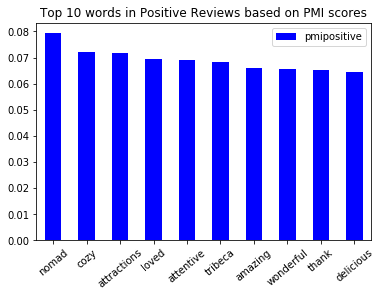

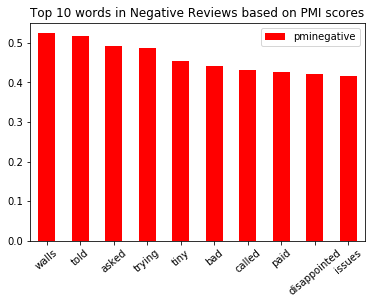

In [112]:
pmiPos_unigram.head(10).plot.bar(rot=40, color='b',
                                 title='Top 10 words in Positive Reviews based on PMI scores')
pmiNeg_unigram.head(10).plot.bar(rot=40, color='r',
                                 title='Top 10 words in Negative Reviews based on PMI scores')
plt.show()

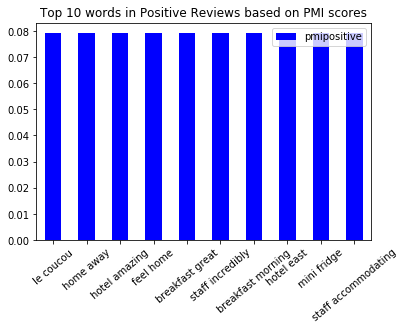

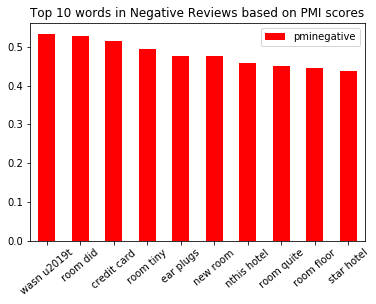

In [113]:
pmiPos_bigram.head(10).plot.bar(rot=40, color='b',
                                 title='Top 10 words in Positive Reviews based on PMI scores')
pmiNeg_bigram.head(10).plot.bar(rot=40, color='r',
                                 title='Top 10 words in Negative Reviews based on PMI scores')
plt.show()

### Pointwise Mutual Information seems like a good metric to summarize the reviews in n-gram tokens!
### By reading the n-gram tokens with high PMI scores for target variable, we can get a sense how much the reviewer did or didn't like the hotels. 

# Visualization
Sometimes, we can learn a lot about the data by visualizing.

## Historgrams

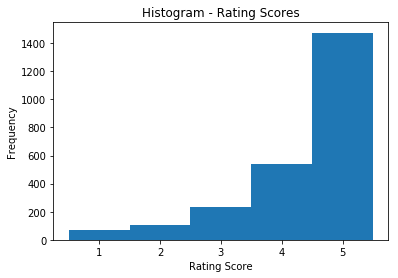

In [43]:
plt.xlabel('Rating Score')
hotelDf['ratingScore'].plot(kind='hist', title='Histogram - Rating Scores',
                            bins=np.arange(1,7)-0.5)
plt.show()

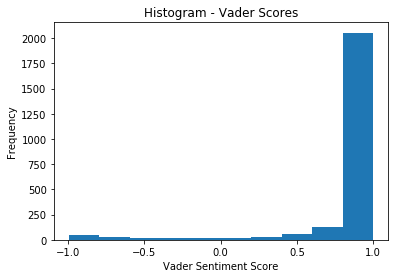

In [44]:
plt.xlabel('Vader Sentiment Score')
hotelDf['vaderScore'].plot(kind='hist', title='Histogram - Vader Scores', 
                           xticks=[-1.0, -0.5, 0.0, 0.5, 1.0])
plt.show()

/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


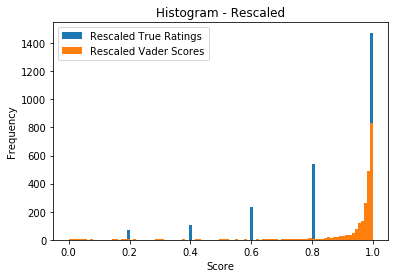

In [45]:
#Overlayed Histogram for GT rating and VD score
#Just for demonstrating, I am dividing the rating score by 5
x = [hotelDf['ratingScore'].as_matrix() / 5]
y = [(hotelDf['vaderScore'].as_matrix() + 1 )/ 2]
bins = np.linspace(0, 1, 100)
plt.hist(x, bins, label='Rescaled True Ratings')
plt.hist(y, bins, label='Rescaled Vader Scores')
plt.title('Histogram - Rescaled')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.show()

## Boxplots

In [46]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = ratingByHotel.sort_values('ratingScore', ascending=False).head(5).hotelName.as_matrix()

tempdf = hotelDf[(hotelDf.hotelName == tp5gthotel[0]) | (hotelDf.hotelName == tp5gthotel[1]) | 
         (hotelDf.hotelName == tp5gthotel[2]) | (hotelDf.hotelName == tp5gthotel[3]) | 
         (hotelDf.hotelName == tp5gthotel[4])]

/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


/Users/vlad/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/vlad/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


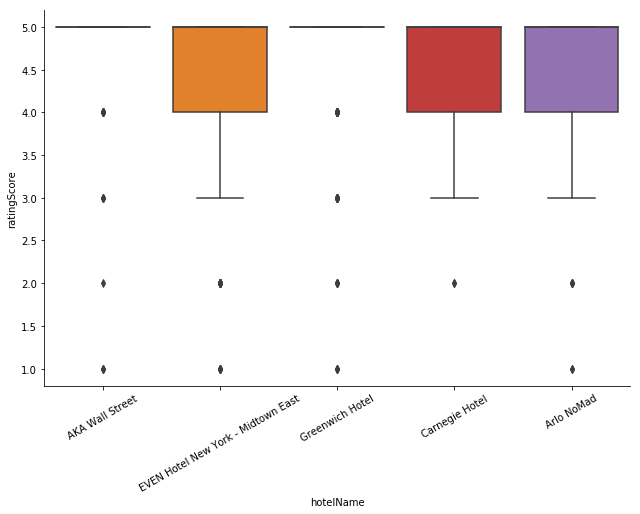

In [47]:
g = sns.factorplot(kind='box',        # Boxplot
               y='ratingScore',       # Y-axis - values for boxplot
               x='hotelName',        # X-axis - first factor
               data=tempdf,        # Dataframe 
               size=6,            # Figure size (x100px)      
               aspect=1.5,        # Width = size * aspect 
               legend_out=False)  # Make legend inside the plot

for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    ax.set_xticklabels(labels, rotation=30) # set new labels
    
plt.show()

/Users/vlad/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/vlad/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


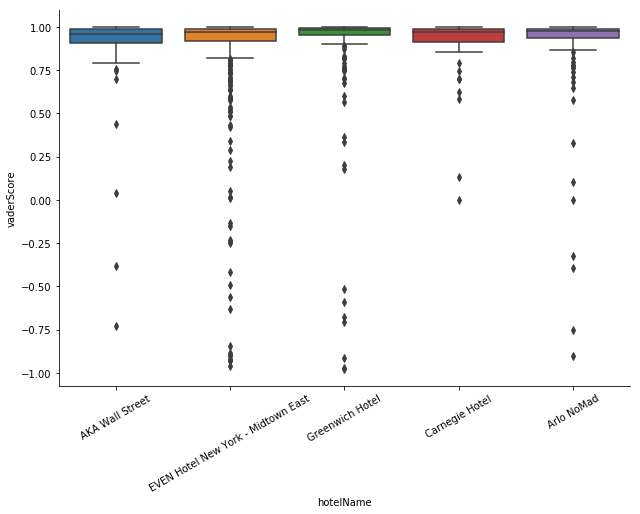

In [48]:
g = sns.factorplot(kind='box',        # Boxplot
               y='vaderScore',       # Y-axis - values for boxplot
               x='hotelName',        # X-axis - first factor
               data=tempdf,        # Dataframe 
               size=6,            # Figure size (x100px)      
               aspect=1.5,        # Width = size * aspect 
               legend_out=False)  # Make legend inside the plot

for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    ax.set_xticklabels(labels, rotation=30) # set new labels
    
plt.show()

## Scatterplots

/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


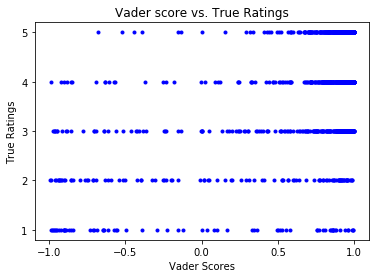

In [49]:
y = hotelDf['ratingScore'].as_matrix()
x = hotelDf['vaderScore'].as_matrix()
plt.title('Vader score vs. True Ratings')
plt.xlabel('Vader Scores')
plt.ylabel('True Ratings')
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([1,2,3,4,5])
plt.plot(x, y, "o", ms=3, color='b')
plt.show()